R => Python  
Source: https://web.stanford.edu/class/stats191/notebooks/Diagnostics_for_multiple_regression.html


NOTE: 
* Not exactly porting R to Python.
* Also not [rpy2](https://rpy2.readthedocs.io/en/version_2.8.x/)

## Diagnostics in multiple linear regression - Part 2
(The original document has part 1 and part 2 together)

### Outline

-   Diagnostics â€“ again

-   Different types of residuals

-   Influence

-   Outlier detection

-   Residual plots:

    -   partial regression (added variable) plot,

    -   partial residual (residual plus component) plot.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import linear_harvey_collier
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, het_goldfeldquandt
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
sm.version.version

'0.9.0'

In [3]:
import scipy; scipy.__version__

'0.18.1'

## Continued from diagnostics_in_multiple_linear_regression_part1.ipynb

## Scottish hill races data

The dataset we will use is based on record times on [Scottish hill races](http://www.statsci.org/data/general/hills.html).

<table>
<tr><td><b>Variable</b></td><td><b>Description</b></td></tr>
<tr><td>Time</td><td>Record time to complete course</td></tr>
<tr><td>Distance</td><td>Distance in the course</td></tr>
<tr><td>Climb</td><td>Vertical climb in the course</td></tr>
</table>


In [4]:
url = "http://www.statsci.org/data/general/hills.txt"

In [5]:
data = pd.read_table(url, header=[0], index_col=0)
data.head()

/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':


,Distance,Climb,Time
Race,,,
Greenmantle,2.5,650,16.083
Carnethy,6.0,2500,48.350
CraigDunain,6.0,900,33.650
BenRha,7.5,800,45.600
BenLomond,8.0,3070,62.267


In [6]:
data.columns

Index(['Distance', 'Climb', 'Time'], dtype='object')

In [7]:
formula = 'Time ~ Distance + Climb'

In [8]:
res = ols(formula, data=data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Time   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     181.7
Date:                Wed, 12 Jun 2019   Prob (F-statistic):           3.40e-18
Time:                        12:03:37   Log-Likelihood:                -142.11
No. Observations:                  35   AIC:                             290.2
Df Residuals:                      32   BIC:                             294.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.9920      4.303     -2.090      0.045     -17.756      -0.228
Distance       6.2180      0.601     10.343      0.000       4.993       7.442
Climb          0.0110      0.002      5.387      0.000       0.007       0.015
==============================================================================
Omnibus:                       47.910   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.976
Skew:                           3.026   Prob(JB):                     1.56e-51
Kurtosis:                      14.127   Cond. No.                     4.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

But is this a good model? 

## Diagnostics

### What can go wrong?

-   Regression function can be wrong: maybe regression function should
    have some other form (see diagnostics for simple linear regression).

-   Model for the errors may be incorrect:

    -   may not be normally distributed.

    -   may not be independent.

    -   may not have the same variance.

-   Detecting problems is more *art* then *science*, i.e. we cannot
    *test* for all possible problems in a regression model.

## Diagnostics

-   Basic idea of diagnostic measures: if model is correct then
    residuals $e_i = Y_i -\widehat{Y}_i, 1 \leq i \leq n$ should look
    like a sample of (not quite independent) $N(0, \sigma^2)$ random
    variables.

## Standard diagnostic plots
please refer to diagnostics_in_multiple_linear_regression_part1.ipynb

## Problems with the errors

### Possible problems & diagnostic checks

-   Errors may not be normally distributed or may not have the same
    variance â€“ qqnorm can help with this. This may not be too important
    in large samples.

-   Variance may not be constant. Can also be addressed in a plot of $X$ vs. $e$
: *fan shape* or other trend indicate
    non-constant variance.

-   Influential observations. Which points â€œaffectâ€ the regression line
    the most?

-   Outliers: points where the model really does not fit! Possibly
    mistakes in data transcription, lab errors, who knows? Should be
    recognized and (hopefully) explained.

## Types of residuals

-   Ordinary residuals: $e_i = Y_i - \widehat{Y}_i$. These measure the
    deviation of predicted value from observed value, but their
    distribution depends on unknown scale, $\sigma$.

-   Internally studentized residuals (`rstandard` in R):
    $$r_i = e_i / SE(e_i) = \frac{e_i}{\widehat{\sigma} \sqrt{1 - H_{ii}}}$$
    
- Above, $H$ is the "hat" matrix $H=X(X^TX)^{-1}X^T$. These are almost $t$-distributed, except
    $\widehat{\sigma}$ depends on $e_i$.

## Types of residuals

- Externally studentized residuals (`rstudent` in R):
    $$t_i = \frac{e_i}{\widehat{\sigma_{(i)}} \sqrt{1 - H_{ii}}} \sim t_{n-p-2}.$$
    These are exactly $t$ distributed so we know their distribution and
    can use them for tests, if desired.
    
- The quantity $\hat{\sigma}^2_{(i)}$ is the MSE of the model fit to all data except case $i$ (i.e. it has $n-1$ observations and $p$ features).

- Numerically, these residuals are highly correlated, as we would expect.


* `rstandard()` produces standardised residuals via normalisation to unit variance using the overall error variance of the residuals/model.

* `rstudent()` produces Studentized residuals in the same way, but it uses a leave-one-out estimate of the error variance.

Source: https://stats.stackexchange.com/questions/63503/does-rstandard-standardize-in-z

In [9]:
infl = res.get_influence()
# Studentized residuals using variance from OLS
# This uses sigma from original estimate does not require leave one out loop
print("resid_studentized_internal: \n", infl.resid_studentized_internal)

# Studentized residuals using LOOO variance
# This uses sigma from leave-one-out estimates requires leave one out loop for observations
print("resid_studentized_external: \n", infl.resid_studentized_external)

# Source: https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.OLSInfluence.html#statsmodels.stats.outliers_influence.OLSInfluence

resid_studentized_internal: 
 [ 0.16454678 -0.53015742 -0.32025768 -0.06153956 -0.86942853  0.0559802
  2.79819456 -0.05476367 -0.08249712  0.29667307  0.53290726 -0.07967326
 -0.65001853  0.72009604 -0.59963166 -0.9815245  -0.2809337   4.56558067
 -0.87696131  0.05103257  0.20862403 -0.10076608 -0.34686042  0.31923417
  0.16732023 -0.82422465 -0.18933769 -0.27965703 -0.01788515 -0.46599435
 -1.17891252 -0.17883396  0.73890152 -0.01944034 -0.81619003]
resid_studentized_external: 
 [ 0.16202389 -0.52411478 -0.31572031 -0.06057395 -0.86602567  0.05510126
  3.16897977 -0.05390372 -0.08120651  0.29240316  0.52685755 -0.07842627
 -0.64404747  0.71456843 -0.59353199 -0.98094545 -0.27685089  7.61084489
 -0.87371292  0.0502309   0.20547819 -0.09919485 -0.34204132  0.31470807
  0.16475719 -0.81999469 -0.18646028 -0.27558968 -0.01760356 -0.46021957
 -1.18639577 -0.17610553  0.73354928 -0.01913429 -0.8118305 ]


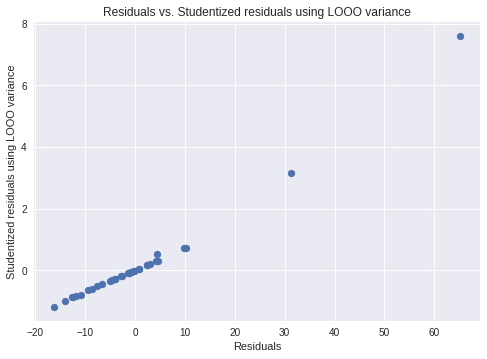

In [10]:
plt.scatter(res.resid, infl.resid_studentized_external)
plt.xlabel("Residuals")
plt.ylabel("Studentized residuals using LOOO variance")
plt.title("Residuals vs. Studentized residuals using LOOO variance")
plt.show()

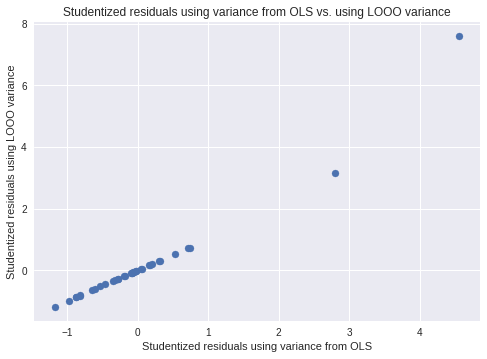

In [11]:
plt.scatter(infl.resid_studentized_internal, infl.resid_studentized_external)
plt.xlabel("Studentized residuals using variance from OLS")
plt.ylabel("Studentized residuals using LOOO variance")
plt.title("Studentized residuals using variance from OLS vs. using LOOO variance")
plt.show()

## Standard diagnostic plots

The first plot is the quantile plot for the residuals, that compares their distribution
to that of a sample of independent normals.

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


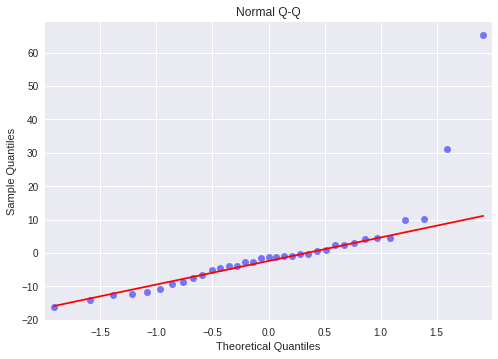

In [12]:
# Normal Q-Q Plot
# how well the distribution of resid fit the normal distribution
# the standardized residuals vs. normal quantiles
qqplot(res.resid, line='q', alpha=0.5)
plt.title('Normal Q-Q')
plt.show()

If the residuals were really normal we'd expect this plot to be roughly on the diagonal.

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


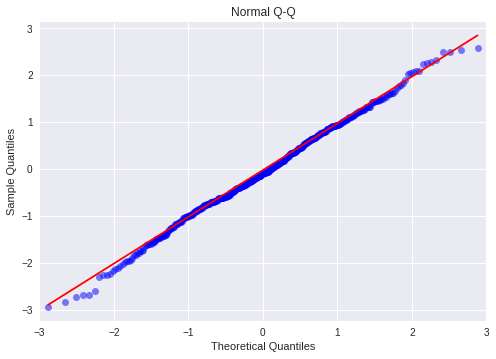

In [13]:
rv = np.random.normal(loc=0, scale=1, size=500)
qqplot(rv, line='q', alpha=0.5)
plt.title('Normal Q-Q')
plt.show()

Two other plots try address the constant variance assumptions. If these plots
have a particular shape (maybe the spread increases with $\hat{Y}$) then maybe the variance is not constant.

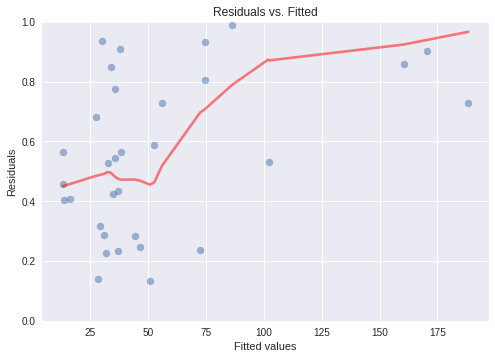

In [14]:
# Scale-location
# abs sqrt(Standardized residuals) vs. Fitted values
norm_resid = res.get_influence().resid_studentized_internal
abs_sqrt_norm_resid = np.sqrt(np.abs(norm_resid))
plt.scatter(res.fittedvalues, abs_sqrt_norm_resid, alpha=0.5)
g = sns.regplot(res.fittedvalues, abs_sqrt_norm_resid, scatter=False, ci=False, lowess=True,
             line_kws={'color': 'red', 'alpha':0.5})
g.set(ylim=(0, 1))
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

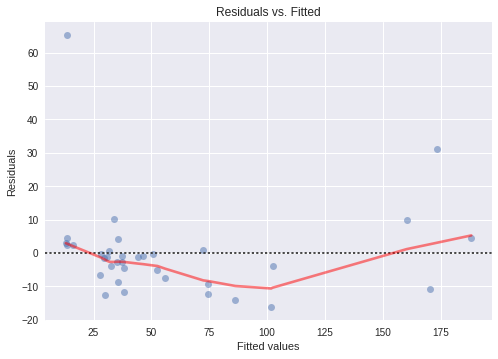

In [15]:
# Residuals vs. Fitted
# with a 'locally weighted scatterplot smoothing (lowess)' regression line 
sns.residplot(res.fittedvalues, 'Time', data=data, lowess=True,
             scatter_kws={'alpha': 0.5},
             line_kws={'color': 'red', 'alpha':0.5})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

## Influence of an observation

Other plots provide an assessment of the `influence` of each observation.
Usually, this is done by dropping an entire case $(y_i, x_i)$ from the dataset and
refitting the model.

-   In this setting, a $\cdot_{(i)}$ indicates $i$-th observation was
    not used in fitting the model.

-   For example: $\widehat{Y}_{j(i)}$ is the regression function
    evaluated at the $j$-th observation predictors BUT the coefficients
    $(\widehat{\beta}_{0(i)}, \dots, \widehat{\beta}_{p(i)})$ were fit
    after deleting $i$-th case from the data.

## Influence of an observation

-   Idea: if $\widehat{Y}_{j(i)}$ is very different than $\widehat{Y}_j$
    (using all the data) then $i$ is an influential point, at least for
    estimating the regression function at $(X_{1,j}, \dots, X_{p,j})$.
    
- Could also look at difference between $\widehat{Y}_{i(i)} - \widehat{Y}_i$, or any other measure.
    
-  There are various standard measures of influence.

## DFFITS

-   $$DFFITS_i = \frac{\widehat{Y}_i - \widehat{Y}_{i(i)}}{\widehat{\sigma}_{(i)} \sqrt{H_{ii}}}$$

-   This quantity measures how much the regression function changes at
    the $i$-th case / observation when the $i$-th case / observation is
    deleted.

-   For small/medium datasets: value of 1 or greater is â€œsuspiciousâ€ (RABE).
    For large dataset: value of $2 \sqrt{(p+1)/n}$.
    
- `R` has its own standard rules similar to the above for marking an observation
as influential.



In [16]:
for attr in dir(infl):
    if not attr.startswith("_"):
        print(attr)

aux_regression_endog
aux_regression_exog
cooks_distance
cov_ratio
det_cov_params_not_obsi
dfbetas
dffits
dffits_internal
endog
ess_press
exog
get_resid_studentized_external
hat_diag_factor
hat_matrix_diag
influence
k_vars
model_class
nobs
params_not_obsi
resid_press
resid_std
resid_studentized_external
resid_studentized_internal
resid_var
results
sigma2_not_obsi
sigma_est
summary_frame
summary_table


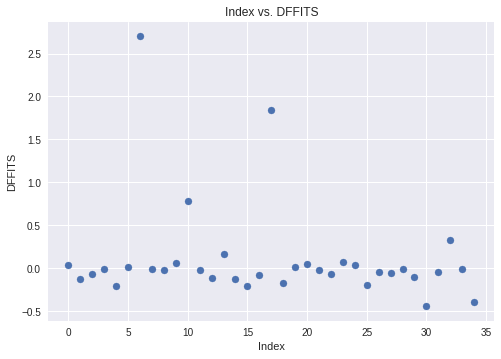

In [17]:
# infl.dffits
"""
- dffits measure for influence of an observation.
- based on resid_studentized_external, uses results from 
leave-one-observation-out loop
- It is recommended that observations with dffits large than a threshold of 
2 sqrt{k / n} where k is the number of parameters, should be investigated.
"""
# infl.dffits_internal
"""
- dffits measure for influence of an observation
- based on resid_studentized_internal, uses original results, 
no nobs loop
"""
plt.scatter(range(data.shape[0]), infl.dffits[0])
plt.xlabel("Index")
plt.ylabel("DFFITS")
plt.title("Index vs. DFFITS")
plt.show()
# Source: https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.OLSInfluence.html

It seems that some observations had a high influence measured by $DFFITS$:

In [18]:
df = infl.summary_frame()
df.columns

Index(['dfb_Intercept', 'dfb_Distance', 'dfb_Climb', 'cooks_d',
       'standard_resid', 'hat_diag', 'dffits_internal', 'student_resid',
       'dffits'],
      dtype='object')

In [19]:
df[df["dffits"] > 0.5]

,dfb_Intercept,dfb_Distance,dfb_Climb,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
Race,,,,,,,,,
BensofJura,-0.890655,-0.712774,2.364618,1.893349,2.798195,0.420435,2.383285,3.168980,2.699091
LairigGhru,-0.301182,0.768716,-0.479849,0.210521,0.532907,0.689816,0.794710,0.526858,0.785688
KnockHill,1.758275,-0.406545,-0.655934,0.407156,4.565581,0.055355,1.105200,7.610845,1.842375


In [20]:
data.loc[df[df["dffits"] > 0.5].index]

,Distance,Climb,Time
Race,,,
BensofJura,16.0,7500,204.617
LairigGhru,28.0,2100,192.667
KnockHill,3.0,350,78.650


It is perhaps not surprising that the longest course and the course with the most elevation gain seemed to have a strong effect on the fitted values. What about `Knock Hill`? We'll come back to this later.

## Cook's distance

Cook's distance measures how much the entire regression function
    changes when the $i$-th case is deleted.

-   $$D_i = \frac{\sum_{j=1}^n(\widehat{Y}_j - \widehat{Y}_{j(i)})^2}{(p+1) \, \widehat{\sigma}^2}$$

-   Should be comparable to $F_{p+1,n-p-1}$: if the â€œ$p$-valueâ€ of $D_i$
    is 50 percent or more, then the $i$-th case is likely influential:
    investigate further. (RABE)
    
- Again, `R` has its own rules similar to the above for marking an observation
as influential.

- What to do after investigation? No easy answer.
    

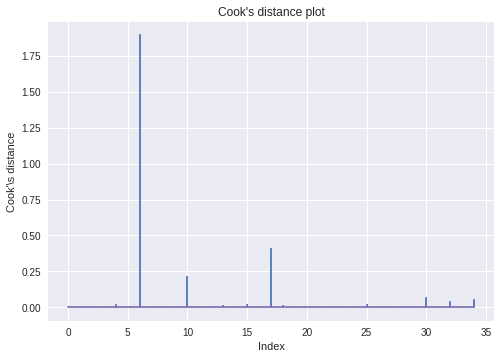

In [21]:
# c: distance
# p: p-value
(c, p) = infl.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.xlabel("Index")
plt.ylabel("Cook'\s distance")
plt.title("Cook's distance plot")
plt.show()

In [22]:
df[df["cooks_d"] > 0.1]

,dfb_Intercept,dfb_Distance,dfb_Climb,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
Race,,,,,,,,,
BensofJura,-0.890655,-0.712774,2.364618,1.893349,2.798195,0.420435,2.383285,3.168980,2.699091
LairigGhru,-0.301182,0.768716,-0.479849,0.210521,0.532907,0.689816,0.794710,0.526858,0.785688
KnockHill,1.758275,-0.406545,-0.655934,0.407156,4.565581,0.055355,1.105200,7.610845,1.842375


In [23]:
data.loc[df[df["cooks_d"] > 0.1].index]

,Distance,Climb,Time
Race,,,
BensofJura,16.0,7500,204.617
LairigGhru,28.0,2100,192.667
KnockHill,3.0,350,78.650


Again, the same 3 races. This is not surprising as both $DFFITS$ and Cook's distance measure changes in fitted values. The difference is that one measures the influence on one fitted value, while the other measures the influence on the entire vector of fitted values.


## DFBETAS

This quantity measures how much the coefficients change when the
    $i$-th case is deleted.


-   $$DFBETAS_{j(i)} = \frac{\widehat{\beta}_j - \widehat{\beta}_{j(i)}}{\sqrt{\widehat{\sigma}^2_{(i)} (X^TX)^{-1}_{jj}}}.$$

   
-   For small/medium datasets: absolute value of 1 or greater is
    "suspicious". For large dataset: absolute value of $2 /  \sqrt{n}$.

In [24]:
dfbetas_df = pd.DataFrame(infl.dfbetas, columns=["Intercept","Distance","Climb"])
dfbetas_df.index = data.index
dfbetas_df.head()

,Intercept,Distance,Climb
Race,,,
Greenmantle,0.037811,-0.016614,-0.004744
Carnethy,-0.059580,0.067215,-0.073396
CraigDunain,-0.048577,-0.006707,0.028033
BenRha,-0.007665,-0.005675,0.008764
BenLomond,-0.050461,0.084709,-0.145005


In [25]:
def DFBETAS_plot_show_table(dfbetas_df, col_name, threshold=1):
    # dfbetass
    plt.scatter(range(data.shape[0]), dfbetas_df[col_name])
    plt.xlabel("Index")
    plt.ylabel("DFBETA ({})".format(col_name))
    plt.title("Index vs. DFBETA ({})".format(col_name))
    plt.show()
    
    # mask
    mask = dfbetas_df[np.abs(dfbetas_df[col_name]) > threshold]
    print(mask)
    
    # table
    return data.loc[mask.index]

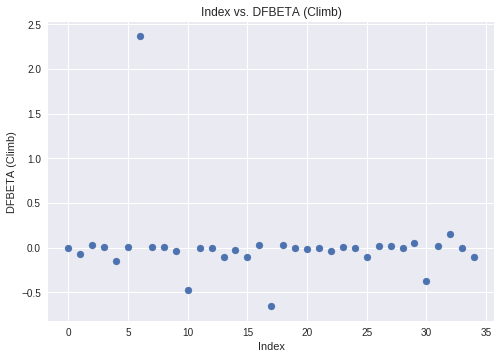

            Intercept  Distance     Climb
Race                                     
BensofJura  -0.890655 -0.712774  2.364618


,Distance,Climb,Time
Race,,,
BensofJura,16.0,7500,204.617


In [26]:
DFBETAS_plot_show_table(dfbetas_df, "Climb")

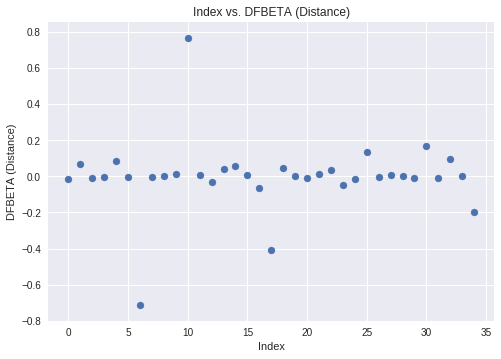

            Intercept  Distance     Climb
Race                                     
BensofJura  -0.890655 -0.712774  2.364618
LairigGhru  -0.301182  0.768716 -0.479849


,Distance,Climb,Time
Race,,,
BensofJura,16.0,7500,204.617
LairigGhru,28.0,2100,192.667


In [27]:
DFBETAS_plot_show_table(dfbetas_df, "Distance", threshold=0.5)

## Outliers

The essential definition of an *outlier* is an observation pair $(Y, X_1, \dots, X_p)$ that does not follow the model, while most other observations seem to follow the model.

-   Outlier in *predictors*: the $X$ values of the observation may lie
    outside the â€œcloudâ€ of other $X$ values. This means you may be
    extrapolating your model inappropriately. The values $H_{ii}$ can be
    used to measure how â€œoutlyingâ€ the $X$ values are.

-   Outlier in *response*: the $Y$ value of the observation may lie very
    far from the fitted model. If the studentized residuals are large:
    observation may be an outlier.
    
- The races at `Bens of Jura` and `Lairig Ghru` seem to be outliers in *predictors*
as they were the highest and longest races, respectively.

- How can we tell if the `Knock Hill` result is an outlier? It seems to have taken much
longer than it should have so maybe it is an outlier in the *response*.


## Outlying $X$ values

One way to detect outliers in the *predictors*, besides just looking at the actual values themselves, is through their leverage values, defined by
$$
\text{leverage}_i = H_{ii} = (X(X^TX)^{-1}X^T)_{ii}.
$$

Not surprisingly, our longest and highest courses show up again. This at least
reassures us that the leverage is capturing some of this "outlying in $X$ space".

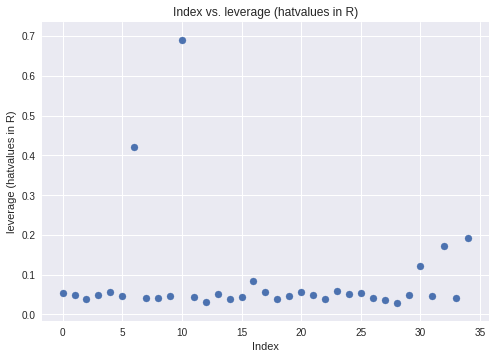

In [28]:
# infl.hat_matrix_diag
"""
"""
plt.scatter(range(data.shape[0]), infl.hat_matrix_diag)
plt.xlabel("Index")
plt.ylabel("leverage (hatvalues in R)")
plt.title("Index vs. leverage (hatvalues in R)")
plt.show()

## Outliers in the response

We will consider a crude outlier test that tries to find residuals that are
"larger" than they should be.

- Since `rstudent` are $t$ distributed, we could just compare them to the $T$ distribution and reject if their absolute value is too large.

- Doing this for every observation results in $n$ different hypothesis tests.

-   This causes a problem: if $n$ is large, if we "threshold" at
    $t_{1-\alpha/2, n-p-2}$ we will get many outliers by chance even if
    model is correct. 
    
- In fact, we expect to see $n \cdot \alpha$
    "outliers" by this test. Every large data set would have outliers in
    it, even if model was entirely correct!
    
    

Let's sample some data from our model to convince ourselves that this is a real problem.

In [29]:
X = np.random.normal(loc=0, scale=1, size=100)
Y = 2 * X + 0.5 + np.random.normal(loc=0, scale=1, size=100)
alpha = 0.1
X = sm.add_constant(X)

In [30]:
res_outliers = sm.OLS(Y, X).fit()

In [31]:
infl_outliers = res_outliers.get_influence()

In [32]:
cutoff = stats.t.ppf(1 - alpha/2, 97)
print("cutoff: ", cutoff)
np.sum(np.abs(infl_outliers.resid_studentized_external) > cutoff)

cutoff:  1.6607146101002037


12

In [33]:
# Bonferroni correction
new_cutoff = stats.t.ppf(1 - alpha/100, 97)
print("new_cutoff: ", new_cutoff)
np.sum(np.abs(infl_outliers.resid_studentized_external) > new_cutoff)

new_cutoff:  3.176387362804584


0

### Multiple comparisons

-   This problem we identified is known as *multiple comparisons* or *simultaneous inference.* 

- When performing many tests (say $m$) each at level $\alpha$, we expect at least $\alpha m$ rejections
even when *all* null hypotheses are true!

- In outlier detection, we are performing $m=n$ hypothesis tests, but might still
like to control the probability of making *any* false positive
errors.
    
- The reason we don't want to make errors here is that we don't
want to throw away data unnecessarily.

- One solution: Bonferroni correction, threshold at
$t_{1 - \alpha/(2*n), n-p-2}$.
    

### Bonferroni correction

- Dividing $\alpha$ by $n$, the number of tests, is known as a *Bonferroni* correction.

-  If we are doing many $t$ (or other) tests, say $m \gg 1$ we can
  control overall false positive rate at $\alpha$ by testing each one
  at level $\alpha/m$. 
  
- In this case $m=n$, but other times we might look at a different number of tests.

### Bonferroni correction

- Essentially the *union bound* for probability.

- **Proof:** when the model is correct, with studentized residuals $T_i$:

    $$\begin{aligned}
        P\left( \text{at least one false positive} \right)
        &  = P \left(\cup_{i=1}^m |T_i| \geq t_{1 - \alpha/(2*m), n-p-2} \right) \\
        & \leq \sum_{i=1}^m P \left( |T_i| \geq t_{1 - \alpha/(2*m), n-p-2} \right) \\
        &  = \sum_{i=1}^m  \frac{\alpha}{m} = \alpha. \\
       \end{aligned}$$

Let's apply this to our data. It turns out that `KnockHill` is a [known error](http://www.statsci.org/data/general/hills.html).

In [34]:
n = data.shape[0]
bonferroni_cutoff = stats.t.ppf(1 - alpha/(2*n), (n-4))

In [35]:
# mask
student_resid_df = df["student_resid"]
bonferroni_mask = student_resid_df[np.abs(infl.resid_studentized_external) > bonferroni_cutoff]
print(bonferroni_mask)

Race
KnockHill    7.610845
Name: student_resid, dtype: float64


In [36]:
# table
data.loc[bonferroni_mask.index]

,Distance,Climb,Time
Race,,,
KnockHill,3.0,350,78.65


### Final plot

The last plot that `R` produces is a plot of residuals against leverage. Points that have
high leverage and large residuals are particularly influential.

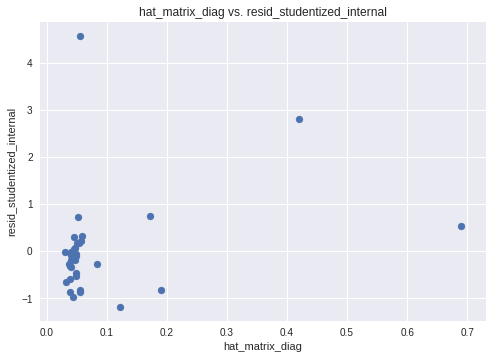

In [37]:
# hat_matrix_diag vs. resid_studentized_internal(rstandard in R)
"""
"""
plt.scatter(infl.hat_matrix_diag, infl.resid_studentized_internal)
plt.xlabel("hat_matrix_diag")
plt.ylabel("resid_studentized_internal")
plt.title("hat_matrix_diag vs. resid_studentized_internal")
plt.show()

`R` will put the IDs of cases that seem to be influential in these (and other plots). Not surprisingly, we see our usual three suspects.


/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in true_divide


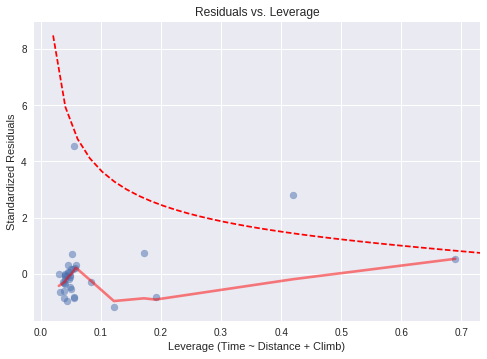

In [38]:
# Residuals vs. Leverage
# See whether an outlier has influence. 
norm_resid = res.get_influence().resid_studentized_internal
leverage = res.get_influence().hat_matrix_diag
plt.scatter(leverage, norm_resid, alpha=0.5)
sns.regplot(leverage, norm_resid, scatter=False, ci=False, lowess=True,
             line_kws={'color': 'red', 'alpha':0.5})
plt.xlabel('Leverage (Time ~ Distance + Climb)')
plt.ylabel('Standardized Residuals')
plt.title('Residuals vs. Leverage')

x = np.linspace(0, 1, 50)
y = np.sqrt((0.5 * len(res.params) * (1 - x)) / x)
plt.plot(x, y, label='Cook\'s distance', ls='--', color='red')
plt.show()

## Influence measures

As mentioned above, `R` has its own rules for flagging points as being influential. To
see a summary of these, one can use the `influence.measures` function.


In [39]:
for attr in dir(infl):
    if not attr.startswith("_"):
        print(attr)

aux_regression_endog
aux_regression_exog
cooks_distance
cov_ratio
det_cov_params_not_obsi
dfbetas
dffits
dffits_internal
endog
ess_press
exog
get_resid_studentized_external
hat_diag_factor
hat_matrix_diag
influence
k_vars
model_class
nobs
params_not_obsi
resid_press
resid_std
resid_studentized_external
resid_studentized_internal
resid_var
results
sigma2_not_obsi
sigma_est
summary_frame
summary_table


In [40]:

infl.influence

# Source: https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.OLSInfluence.influence.html#statsmodels.stats.outliers_influence.OLSInfluence.influence

array([ 1.33446110e-01, -3.94733949e-01, -1.84067983e-01, -4.48933048e-02,
       -7.25559049e-01,  3.93845885e-02,  2.26787251e+01, -3.36759985e-02,
       -4.97514075e-02,  2.03719236e-01,  9.68654372e+00, -5.19491539e-02,
       -3.13406212e-01,  5.56183790e-01, -3.47997029e-01, -6.53679332e-01,
       -3.57974944e-01,  3.81604818e+00, -5.05340390e-01,  3.51998414e-02,
        1.78330636e-01, -7.31502260e-02, -2.06613466e-01,  2.82083033e-01,
        1.27834678e-01, -6.84316307e-01, -1.16430037e-01, -1.57220650e-01,
       -7.97561906e-03, -3.38209103e-01, -2.24436861e+00, -1.27630775e-01,
        2.04425400e+00, -1.17439674e-02, -2.54340837e+00])

In [41]:
infl.summary_frame()

,dfb_Intercept,dfb_Distance,dfb_Climb,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
Race,,,,,,,,,
Greenmantle,0.037811,-0.016614,-0.004744,0.000513,0.164547,0.053756,0.039219,0.162024,0.038618
Carnethy,-0.059580,0.067215,-0.073396,0.004875,-0.530157,0.049464,-0.120939,-0.524115,-0.119560
CraigDunain,-0.048577,-0.006707,0.028033,0.001365,-0.320258,0.038404,-0.064002,-0.315720,-0.063095
BenRha,-0.007665,-0.005675,0.008764,0.000064,-0.061540,0.048489,-0.013892,-0.060574,-0.013674
BenLomond,-0.050461,0.084709,-0.145005,0.014741,-0.869429,0.055271,-0.210295,-0.866026,-0.209472
Goatfell,0.003484,-0.004316,0.007576,0.000051,0.055980,0.046805,0.012405,0.055101,0.012210
BensofJura,-0.890655,-0.712774,2.364618,1.893349,2.798195,0.420435,2.383285,3.168980,2.699091
Cairnpapple,-0.008443,-0.001648,0.005562,0.000043,-0.054764,0.041033,-0.011328,-0.053904,-0.011150
Scolty,-0.014369,0.000913,0.006161,0.000095,-0.082497,0.040258,-0.016896,-0.081207,-0.016632


In [42]:
# R has asterisks but I could not find in statsmodels

While not specified in the documentation, the meaning of the asterisks can be found
by reading the code. The function `is.influential` makes the decisions
to flag cases as influential or not. 

- We see that the `DFBETAS` are thresholded at 1.

- We see that `DFFITS` is thresholded at `3 * sqrt((p+1)/(n-p-1))`.

- Etc. 

## Problems in the regression function

-   True regression function may have higher-order non-linear terms,
    polynomial or otherwise.

-   We may be missing terms involving more than one ${X}_{(\cdot)}$,
    i.e. ${X}_i \cdot {X}_j$ (called an *interaction*).

-   Some simple plots: *added-variable* and *component plus residual*
    plots can help to find nonlinear functions of *one variable*.
    
- I find these plots of somewhat limited use in practice, but we will go over them as
possibly useful diagnostic tools.


### Added variable plots

- The plots can be helpful for finding influential points, outliers. The functions can 
be found in the `car` package.

-   Procedure:

    -   Let $\tilde{e}_{X_j,i}, 1\leq i \leq n$ be the residuals after
        regressing $X_j$ onto all columns of $X$ except
        $X_j$;

    -   Let $e_{X_j,i}$ be the residuals after regressing ${Y}$ onto
        all columns of ${X}$ except ${X}_j$;

    -   Plot $\tilde{e}_{X_j}$ against $e_{X_j}$.
    
    - If the (partial regression) relationship is linear this plot should look linear.


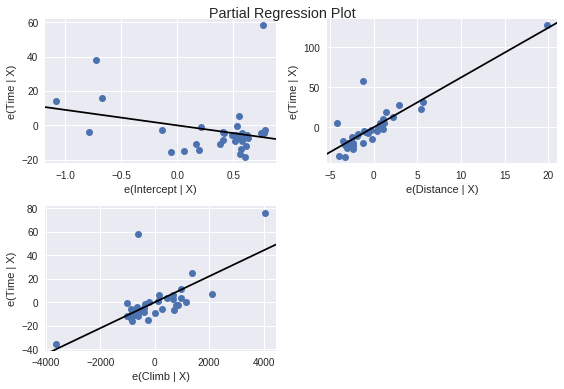

In [43]:
# Added variable plots grid (Partial regression plot grid)
fig = sm.graphics.plot_partregress_grid(res)
plt.show()

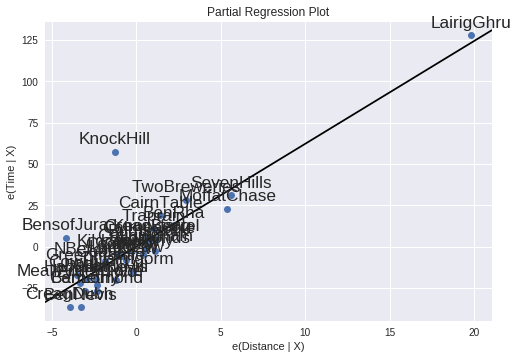

In [44]:
# Added variable plots (Partial regression plots)
"""
endog      : endogenous or response variable. 
exog_i     : exogenous, explanatory variable. 
exog_others: other exogenous, explanatory variables. 
"""
fig = sm.graphics.plot_partregress(endog="Time", 
                                   exog_i="Distance", 
                                   exog_others=["Climb"], 
                                   data=data)
plt.show()
# Source: https://www.statsmodels.org/devel/generated/statsmodels.graphics.regressionplots.plot_partregress.html

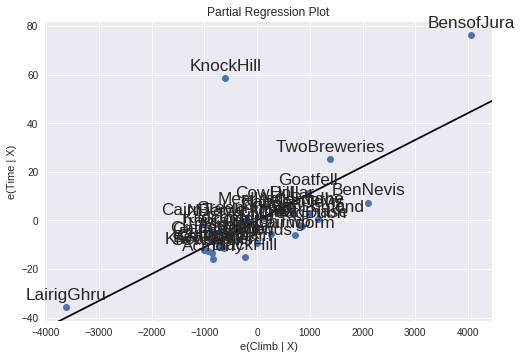

In [45]:
# Added variable plots (Partial regression plots)
"""
endog      : endogenous or response variable. 
exog_i     : exogenous, explanatory variable. 
exog_others: other exogenous, explanatory variables. 
"""
fig = sm.graphics.plot_partregress(endog="Time", 
                                   exog_i="Climb", 
                                   exog_others=["Distance"], 
                                   data=data)
plt.show()
# Source: https://www.statsmodels.org/devel/generated/statsmodels.graphics.regressionplots.plot_partregress.html

### Component + residual plots

-   Similar to added variable, but may be more helpful in identifying nonlinear relationships.

-   Procedure: plot $X_{ij}, 1 \leq i \leq n$ vs.
    $e_i + \widehat{\beta}_j \cdot X_{ij} , 1 \leq i \leq n$.
   
- The green line is a non-parametric smooth of the scatter plot that may suggest
relationships other than linear.

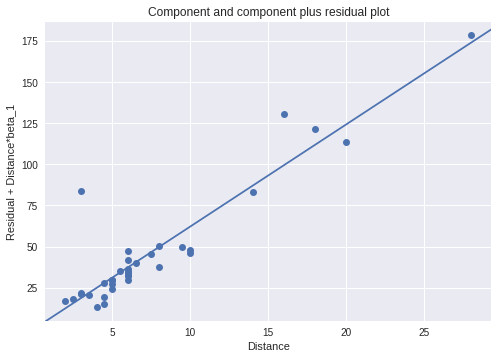

In [46]:
# CCPR(Component-Component plus Residual)
"""
results : uses exog and params of the result instance
exog_idx: Exogenous, explanatory variable
"""
fig = sm.graphics.plot_ccpr(results=res, exog_idx=1)
plt.show()
# Source: https://www.statsmodels.org/dev/generated/statsmodels.graphics.regressionplots.plot_ccpr.html

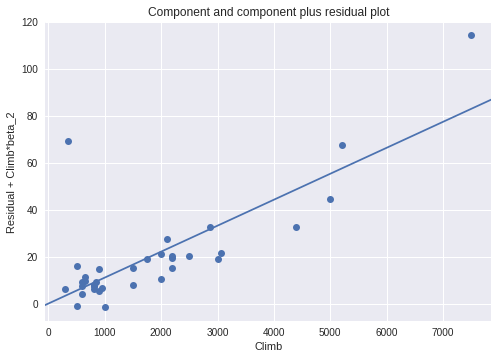

In [47]:
# CCPR(Component-Component plus Residual)
"""
results : uses exog and params of the result instance
exog_idx: Exogenous, explanatory variable
"""
fig = sm.graphics.plot_ccpr(results=res, exog_idx=2)
plt.show()
# Source: https://www.statsmodels.org/dev/generated/statsmodels.graphics.regressionplots.plot_ccpr.html